## Re-analysis of Park et al. findings using gene expression-based mutation signatures

TODO: document

In [1]:
from pathlib import Path
import pickle as pkl

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys; sys.path.append('..')
import config as cfg

%load_ext autoreload
%autoreload 2

In [2]:
# park geneset info
park_loss_data = cfg.data_dir / 'park_loss_df.tsv'
park_gain_data = cfg.data_dir / 'park_gain_df.tsv'

# park gene/cancer type predictions
park_preds_dir = cfg.data_dir / 'park_genes_preds'

# mutation and copy number data
pancancer_pickle = Path('/home/jake/research/mpmp/data/pancancer_data.pkl')

### Load mutation/copy number info

For now, just use binary mutation status from the pancancer repo. In the future we could pull more granular info from MC3, but it would take some engineering of `1_get_mutation_counts` to do this for lots of genes.

In [3]:
park_loss_df = pd.read_csv(park_loss_data, sep='\t', index_col=0)
park_loss_df.head()

,Gene,Tissue,Effect,Pval,FDR,LogFDR,Target,classification
AJUBA_HNSC,AJUBA,HNSC,-0.936050,8.732955e-03,0.045816,1.338886,A_Hit,TSG
ARID1A_LGG,ARID1A,LGG,-0.904202,1.956617e-02,0.076291,1.117471,A_Hit,TSG
ARID1A_STAD,ARID1A,STAD,1.133548,3.979932e-04,0.000294,3.517309,B_Target,TSG
ARID1A_UCEC,ARID1A,UCEC,1.597876,3.451937e-07,0.000000,5.000000,B_Target,TSG
ARID2_LIHC,ARID2,LIHC,-0.978419,1.019284e-02,0.050276,1.298552,A_Hit,TSG


In [4]:
park_gain_df = pd.read_csv(park_gain_data, sep='\t', index_col=0)
park_gain_df.head()

,Gene,Tissue,Effect,Pval,FDR,LogFDR,Target,classification
ARID1A_UCEC,ARID1A,UCEC,-2.351526,1.154365e-03,-0.000447,3.340299,B_Target,TSG
ATRX_LGG,ATRX,LGG,1.440987,4.025141e-08,0.000000,5.000000,A_Hit,TSG
BRAF_SKCM,BRAF,SKCM,1.239939,2.042839e-11,0.000000,5.000000,A_Hit,Oncogene
BRAF_THCA,BRAF,THCA,-2.449684,7.509064e-04,-0.000209,3.659041,B_Target,Oncogene
CTNNB1_UCEC,CTNNB1,UCEC,-1.257861,1.597968e-02,0.096292,1.016366,B_Target,Oncogene


In [5]:
with open(pancancer_pickle, 'rb') as f:
    pancancer_data = pkl.load(f)

In [6]:
mutation_df = pancancer_data[1]
print(mutation_df.shape)
mutation_df.iloc[:5, :5]

(9074, 20938)


,5S_rRNA,A1BG,A1CF,A2M,A2ML1
SAMPLE_BARCODE,,,,,
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,0,0,0,0,0
TCGA-02-2483-01,0,0,0,0,0
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


In [7]:
copy_loss_df = pancancer_data[2]
print(copy_loss_df.shape)
copy_loss_df.iloc[:5, :5]

(9074, 25128)


,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,0,0,0,0,0
TCGA-02-2483-01,0,0,0,0,0
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


In [8]:
copy_gain_df = pancancer_data[3]
print(copy_gain_df.shape)
copy_gain_df.iloc[:5, :5]

(9074, 25128)


,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A
TCGA-02-0047-01,0,0,0,0,0
TCGA-02-0055-01,0,0,0,0,0
TCGA-02-2483-01,0,0,0,0,0
TCGA-02-2485-01,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0


### Classify genes/cancer types into "classes"

In [Park et al. 2021](https://www.nature.com/articles/s41467-021-27242-3), they describe 4 "classes" of driver genes:

1. Genes that function exclusively as one-hit drivers, no significant co-occurrence with CNAs (we aren't concerned with those here)
2. Genes that interact with CNA loss in at least one cancer type - "two-hit loss" drivers (i.e. classical tumor suppressors)
3. Genes that interact with CNA gain in at least one cancer type - "two-hit gain" drivers (for some examples/explanation of "two-hit" oncogenes, see [this paper](https://www.nature.com/articles/s41586-020-2175-2))
4. Genes that interact with both CNA loss and CNA gain across multiple cancer types - "two-hit loss and gain" drivers

Here, we label each of the genes from the Park et al. data with their "class", since we want to segment our analyses in this way too.

In [9]:
# our datasets are already filtered for significance, so genes that appear
# in both loss/gain tables are class 4
# others are class 2/3 for loss/gain tables respectively

class_4_genes = (
    set(park_loss_df.Gene.unique()).intersection(
    set(park_gain_df.Gene.unique())
))
print(class_4_genes)

{'EPAS1', 'NRAS', 'PPP2R1A', 'ARID1A', 'CUL3', 'TP53', 'CTNNB1'}


In [10]:
def gene_to_class(g):
    return 'class 4' if g in class_4_genes else 'class 2'

loss_class = {g: gene_to_class(g) for g in park_loss_df.Gene.unique()}

park_loss_df['class'] = park_loss_df.Gene.map(loss_class)
park_loss_df.head()

,Gene,Tissue,Effect,Pval,FDR,LogFDR,Target,classification,class
AJUBA_HNSC,AJUBA,HNSC,-0.936050,8.732955e-03,0.045816,1.338886,A_Hit,TSG,class 2
ARID1A_LGG,ARID1A,LGG,-0.904202,1.956617e-02,0.076291,1.117471,A_Hit,TSG,class 4
ARID1A_STAD,ARID1A,STAD,1.133548,3.979932e-04,0.000294,3.517309,B_Target,TSG,class 4
ARID1A_UCEC,ARID1A,UCEC,1.597876,3.451937e-07,0.000000,5.000000,B_Target,TSG,class 4
ARID2_LIHC,ARID2,LIHC,-0.978419,1.019284e-02,0.050276,1.298552,A_Hit,TSG,class 2


In [11]:
def gene_to_class(g):
    return 'class 4' if g in class_4_genes else 'class 3'

gain_class = {g: gene_to_class(g) for g in park_gain_df.Gene.unique()}

park_gain_df['class'] = park_gain_df.Gene.map(gain_class)
park_gain_df.head()

,Gene,Tissue,Effect,Pval,FDR,LogFDR,Target,classification,class
ARID1A_UCEC,ARID1A,UCEC,-2.351526,1.154365e-03,-0.000447,3.340299,B_Target,TSG,class 4
ATRX_LGG,ATRX,LGG,1.440987,4.025141e-08,0.000000,5.000000,A_Hit,TSG,class 3
BRAF_SKCM,BRAF,SKCM,1.239939,2.042839e-11,0.000000,5.000000,A_Hit,Oncogene,class 3
BRAF_THCA,BRAF,THCA,-2.449684,7.509064e-04,-0.000209,3.659041,B_Target,Oncogene,class 3
CTNNB1_UCEC,CTNNB1,UCEC,-1.257861,1.597968e-02,0.096292,1.016366,B_Target,Oncogene,class 4


### Retrieve and format per-sample information

* Sample ID, gene/tissue (multi-index)
* Gene classification
* Mutation status for sample in gene
* CNV status for sample in gene
* Classifier probability

In [12]:
from scipy.special import expit

def get_info_for_gene_and_tissue(identifier, classification):
    gene, tissue = identifier.split('_')
    preds_file = park_preds_dir / 'expression_{}_raw_preds.tsv'.format(identifier)
    preds_df = pd.read_csv(preds_file, sep='\t', skiprows=1,
                           names=['sample_id', gene])
    
    # get predictions for identifier
    preds_df['identifier'] = identifier
    preds_df['positive_prob'] = expit(preds_df[gene])
    preds_df.drop(columns=[gene], inplace=True)
    
    # get mutation status for samples
    preds_df['mutation_status'] = mutation_df.loc[preds_df.index, gene]
    
    # get copy status for samples
    if classification == 'TSG':
        copy_status = copy_loss_df.loc[preds_df.index, gene]
    elif classification == 'Oncogene':
        copy_status = copy_gain_df.loc[preds_df.index, gene]
    preds_df['copy_status'] = copy_status
        
    def status_from_mut_info(row):
        if row['mutation_status'] == 1 and row['copy_status'] == 1:
            return 'both'
        elif row['mutation_status'] == 1 or row['copy_status'] == 1:
            return 'one'
        else:
            return 'none'
        
    preds_df['status'] = preds_df.apply(status_from_mut_info, axis=1)
    
    return preds_df

In [13]:
plot_id = 'CDH1_BRCA'
df = get_info_for_gene_and_tissue(plot_id, 'TSG')
print(df.mutation_status.isna().sum())
print(df.copy_status.isna().sum())
df.head()

0
0


,sample_id,identifier,positive_prob,mutation_status,copy_status,status
TCGA-3C-AAAU-01,-3.842660,CDH1_BRCA,0.505246,0,0,none
TCGA-3C-AALJ-01,-2.247544,CDH1_BRCA,0.523872,0,0,none
TCGA-4H-AAAK-01,1.771718,CDH1_BRCA,0.701546,1,0,one
TCGA-A1-A0SE-01,0.297351,CDH1_BRCA,0.639638,1,0,one
TCGA-A1-A0SG-01,-0.231388,CDH1_BRCA,0.608833,0,1,one


Text(0.5, 1.0, 'Distribution of positive probabilities for CDH1_BRCA')

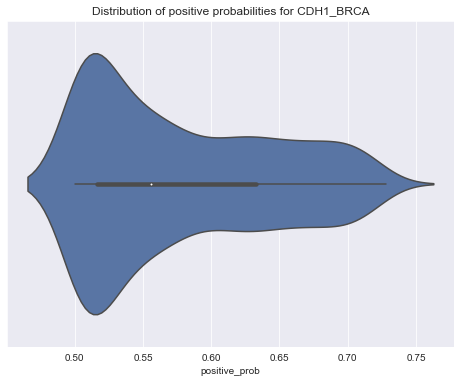

In [14]:
sns.set({'figure.figsize': (8, 6)})
sns.violinplot(x=df.positive_prob)
plt.title('Distribution of positive probabilities for {}'.format(plot_id))

Text(0.5, 1.0, 'CDH1_BRCA')

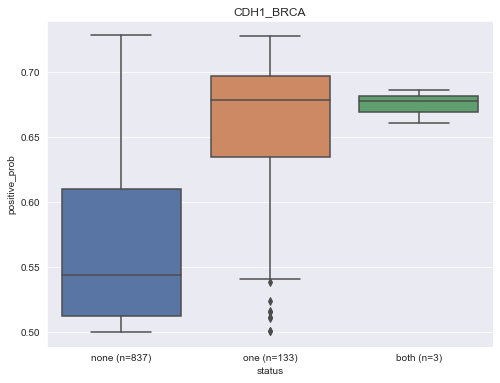

In [15]:
order = ['none', 'one', 'both']
sns.set({'figure.figsize': (8, 6)})
sns.boxplot(data=df, x='status', y='positive_prob',
            order=order)

def get_counts(status):
    un = np.unique(status, return_counts=True)
    return {s: c for s, c in zip(*un)}

count_map = get_counts(df.status.values)
plt.xticks(np.arange(3),
           ['{} (n={})'.format(l, count_map[l]) for l in order])
plt.title(plot_id)

### Averages across each "class" of genes

In [16]:
park_df = pd.concat((park_loss_df, park_gain_df))
print(park_df.shape)
park_df.head()

(109, 9)


,Gene,Tissue,Effect,Pval,FDR,LogFDR,Target,classification,class
AJUBA_HNSC,AJUBA,HNSC,-0.936050,8.732955e-03,0.045816,1.338886,A_Hit,TSG,class 2
ARID1A_LGG,ARID1A,LGG,-0.904202,1.956617e-02,0.076291,1.117471,A_Hit,TSG,class 4
ARID1A_STAD,ARID1A,STAD,1.133548,3.979932e-04,0.000294,3.517309,B_Target,TSG,class 4
ARID1A_UCEC,ARID1A,UCEC,1.597876,3.451937e-07,0.000000,5.000000,B_Target,TSG,class 4
ARID2_LIHC,ARID2,LIHC,-0.978419,1.019284e-02,0.050276,1.298552,A_Hit,TSG,class 2


In [17]:
park_info = []
for identifier in park_df.index:
    try:
        classification = park_df.loc[identifier, 'classification']
        info_df = get_info_for_gene_and_tissue(identifier, classification)
    except ValueError:
        classification = park_df.loc[identifier, 'classification'].values[0]
        info_df = get_info_for_gene_and_tissue(identifier, classification)
    except FileNotFoundError:
        continue
    park_info.append(info_df)
    
park_info_df = pd.concat(park_info)
print(park_info_df.shape)
park_info_df.head()

(43118, 6)


,sample_id,identifier,positive_prob,mutation_status,copy_status,status
TCGA-BA-5557-01,-0.612853,AJUBA_HNSC,0.586959,0,0,none
TCGA-BA-6871-01,-0.452735,AJUBA_HNSC,0.595972,0,0,none
TCGA-BA-6872-01,-0.247102,AJUBA_HNSC,0.607910,0,0,none
TCGA-BA-7269-01,0.620609,AJUBA_HNSC,0.657091,0,0,none
TCGA-BA-A6D8-01,0.663286,AJUBA_HNSC,0.659260,0,0,none


In [18]:
def id_to_class(identifier):
    if type(park_df.loc[identifier, 'class']) == pd.Series:
        return park_df.loc[identifier, 'class'].values[0]
    else:
        return park_df.loc[identifier, 'class']

park_info_df['class'] = park_info_df['identifier'].apply(id_to_class)
park_info_df.head()

,sample_id,identifier,positive_prob,mutation_status,copy_status,status,class
TCGA-BA-5557-01,-0.612853,AJUBA_HNSC,0.586959,0,0,none,class 2
TCGA-BA-6871-01,-0.452735,AJUBA_HNSC,0.595972,0,0,none,class 2
TCGA-BA-6872-01,-0.247102,AJUBA_HNSC,0.607910,0,0,none,class 2
TCGA-BA-7269-01,0.620609,AJUBA_HNSC,0.657091,0,0,none,class 2
TCGA-BA-A6D8-01,0.663286,AJUBA_HNSC,0.659260,0,0,none,class 2


In [19]:
park_info_df.groupby(by=['class']).count()

,sample_id,identifier,positive_prob,mutation_status,copy_status,status
class,,,,,,
class 2,23144,23144,23144,23144,23144,23144
class 3,6763,6763,6763,6763,6763,6763
class 4,13211,13211,13211,13211,13211,13211


([<matplotlib.axis.XTick at 0x7f0f8fc7dfd0>,
 [Text(0, 0, 'none (n=33954)'),
  Text(1, 0, 'one (n=8974)'),
  Text(2, 0, 'both (n=190)')])

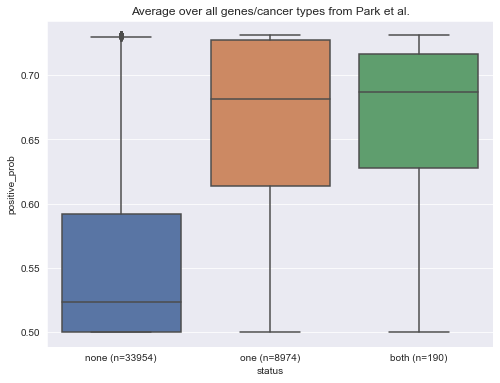

In [20]:
order = ['none', 'one', 'both']
sns.set({'figure.figsize': (8, 6)})
sns.boxplot(data=park_info_df, x='status', y='positive_prob',
            order=order)
plt.title('Average over all genes/cancer types from Park et al.')

def get_counts(status):
    un = np.unique(status, return_counts=True)
    return {s: c for s, c in zip(*un)}

count_map = get_counts(park_info_df.status.values)
plt.xticks(np.arange(3),
           ['{} (n={})'.format(l, count_map[l]) for l in order])

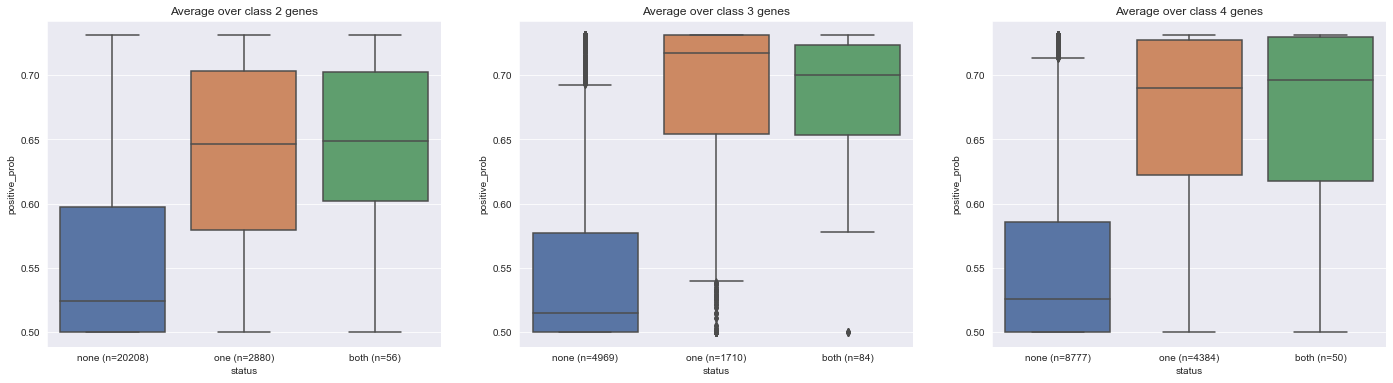

In [21]:
sns.set({'figure.figsize': (24, 6)})
fig, axarr = plt.subplots(1, 3)

for ix, class_label in enumerate(['class 2', 'class 3', 'class 4']):
    ax = axarr[ix]
    plot_df = park_info_df[park_info_df['class'] == class_label]
    sns.boxplot(data=plot_df, x='status', y='positive_prob',
                order=order, ax=ax)
    ax.set_title('Average over {} genes'.format(class_label))
    count_map = get_counts(plot_df.status.values)
    ax.set_xticks(np.arange(3), ['{} (n={})'.format(l, count_map[l]) for l in order])